# Data Source

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from tabulate import tabulate
from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency, pearsonr

## Dateset Overview

In [ ]:
# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cardio_data_processed.csv')
file_path = '/content/cardio_data_processed.csv'
data = pd.read_csv(file_path)

data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2,Hypertension Stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal,Normal


In [ ]:
# Check the number of columns and rows
num_rows, num_cols = data.shape

# Check the number of unique patient IDs
unique_patient_ids = data['id'].nunique()

# Print the results
print(f"Number of columns: {num_cols}")
print(f"Number of rows: {num_rows}")
print(f"Number of unique patient IDs: {unique_patient_ids}")


Number of columns: 17
Number of rows: 68205
Number of unique patient IDs: 68205


## Data Types and Feature Classification

In this section, we categorize features into **numerical, ordinal, and binary** based on their data types and unique value counts. This helps in understanding the dataset structure and guides further preprocessing steps.

The following code:
- Identifies numerical, ordinal, and binary features.
- Prints out their counts and names.

In [ ]:
# Reload the dataset with the newly uploaded file
data = pd.read_csv(file_path)

# Function to classify features into numerical, ordinal, and binary properly
def classify_features(df):
    # Initial classification based on data types
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    ordinal_features = df.select_dtypes(include=['object']).columns.tolist()

    # Identify ordinal-like numerical features (e.g., cholesterol with values 1, 2, 3)
    threshold = 10  # If a numerical feature has <= 10 unique values, consider it ordinal
    forced_ordinal = [col for col in numerical_features if df[col].nunique() <= threshold]

    # Add to ordinal features and remove from numerical
    ordinal_features.extend(forced_ordinal)
    numerical_features = [col for col in numerical_features if col not in forced_ordinal]

    # Identify binary features (features with exactly 2 unique values)
    binary_features = [col for col in ordinal_features if df[col].nunique() == 2]

    # Remove binary features from ordinal list to avoid duplication
    ordinal_features = [col for col in ordinal_features if col not in binary_features]

    # Remove binary features from numerical list to avoid misclassification
    numerical_features = [col for col in numerical_features if col not in binary_features]
    binary_features.remove('cardio')

    return numerical_features, ordinal_features, binary_features

# Classify features using the improved function
numerical_features, ordinal_features, binary_features = classify_features(data)

# Print results
print(f"Numerical Features: {len(numerical_features)} -> {numerical_features}")
print(f"Ordinal Features: {len(ordinal_features)} -> {ordinal_features}")
print(f"Binary Features: {len(binary_features)} -> {binary_features}")



Numerical Features: 8 -> ['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']
Ordinal Features: 4 -> ['bp_category', 'bp_category_encoded', 'cholesterol', 'gluc']
Binary Features: 4 -> ['gender', 'smoke', 'alco', 'active']


# Exploratory Data Analysis (EDA)
The goal of our Exploratory Data Analysis (EDA) is to detect missing data, duplicates and outliers, identify patterns, explore relationships between various features, and pinpoint key factors that affect the occurrence of CVD in individuals.

## Determining Target Variable Balance

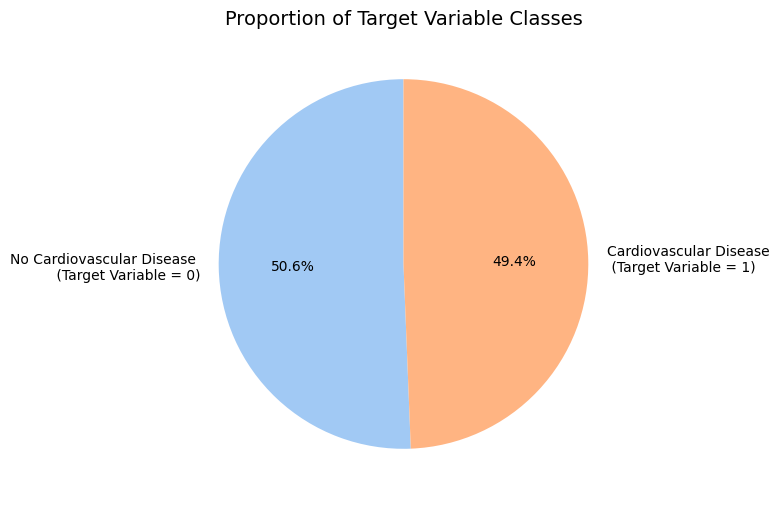

In [ ]:
# Create a pie chart for the target variable 'cardio'
plt.figure(figsize=(6, 6))
data['cardio'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel"),
    labels=['No Cardiovascular Disease \n (Target Variable = 0)', 'Cardiovascular Disease \n (Target Variable = 1)']
)

# Add title and display the plot
plt.title("Proportion of Target Variable Classes", fontsize=14)
plt.ylabel("")  # Remove y-axis label for better visuals
plt.show()


## Target Class Distribution by Ordinal Variables


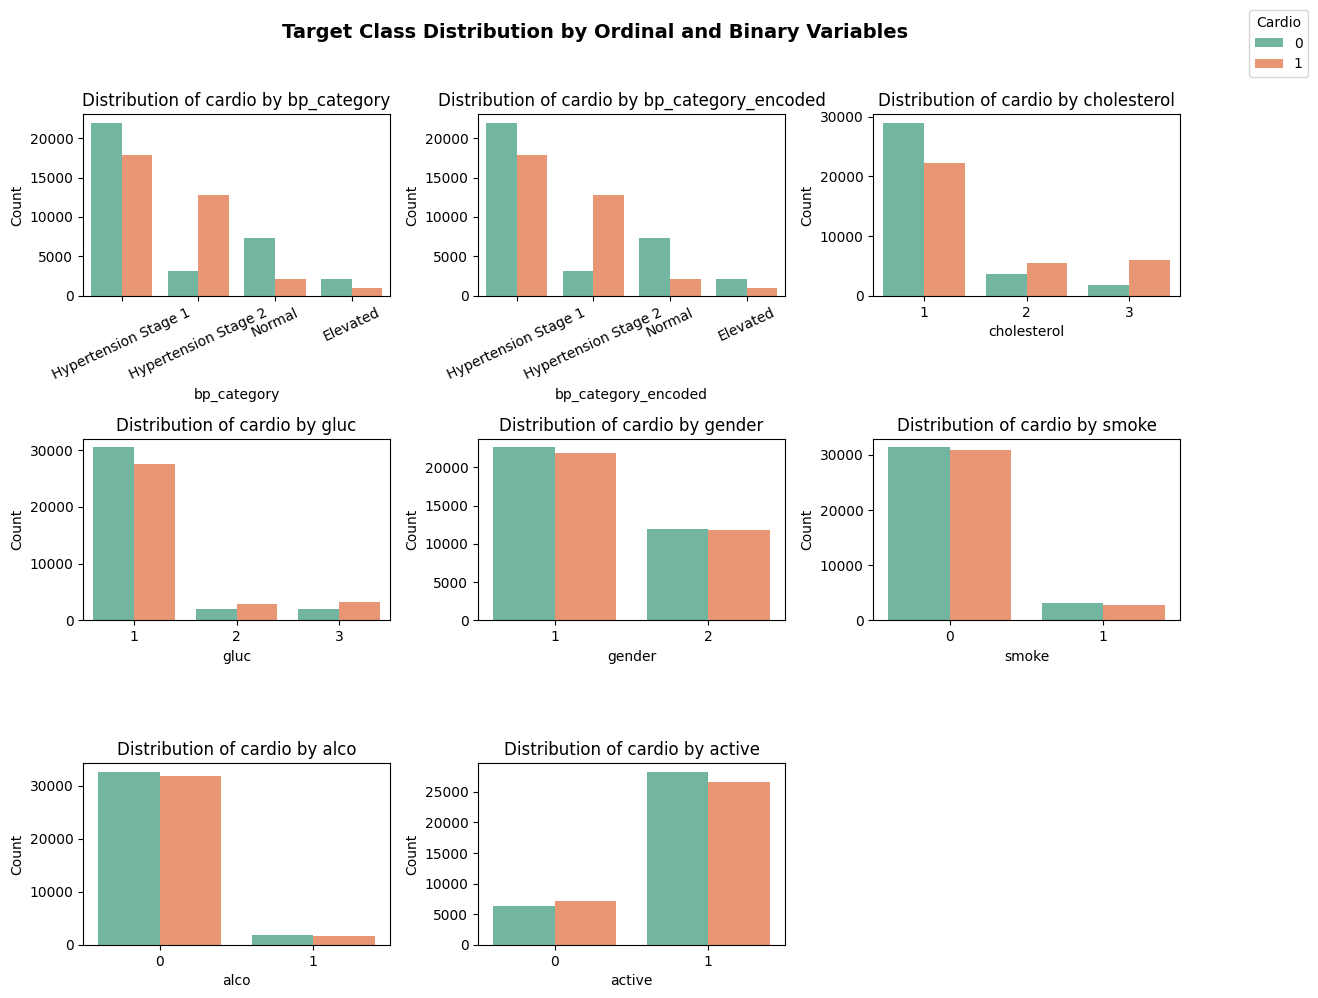

In [ ]:
# Classify features using the improved function
numerical_features, ordinal_features, binary_features = classify_features(data)

# Re-import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Combine ordinal and binary features for visualization
plot_features = ordinal_features + binary_features

# Determine the number of rows and columns dynamically
num_features = len(plot_features)
num_cols = 3 # Set a fixed number of columns
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Adjust rows dynamically

# Set up the figure and axes for multiple subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))
fig.suptitle("Target Class Distribution by Ordinal and Binary Variables", fontsize=14, fontweight='bold')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot countplots
for i, feature in enumerate(plot_features):
    plot = sns.countplot(data=data, x=feature, hue="cardio", palette="Set2", ax=axes[i])
    axes[i].set_title(f"Distribution of cardio by {feature}")
    axes[i].set_ylabel("Count")

    # Rotate x-axis labels only for 'bp_category' and 'bp_category_encoded'
    if feature in ['bp_category', 'bp_category_encoded']:
        axes[i].tick_params(axis='x', rotation=25)  # Rotate text

    # Remove legend from all subplots
    axes[i].get_legend().remove()

# Create a single legend outside the plot
handles, labels = plot.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.10, 1), title="Cardio")

# Remove any empty subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()




## Numerical Features Distribution

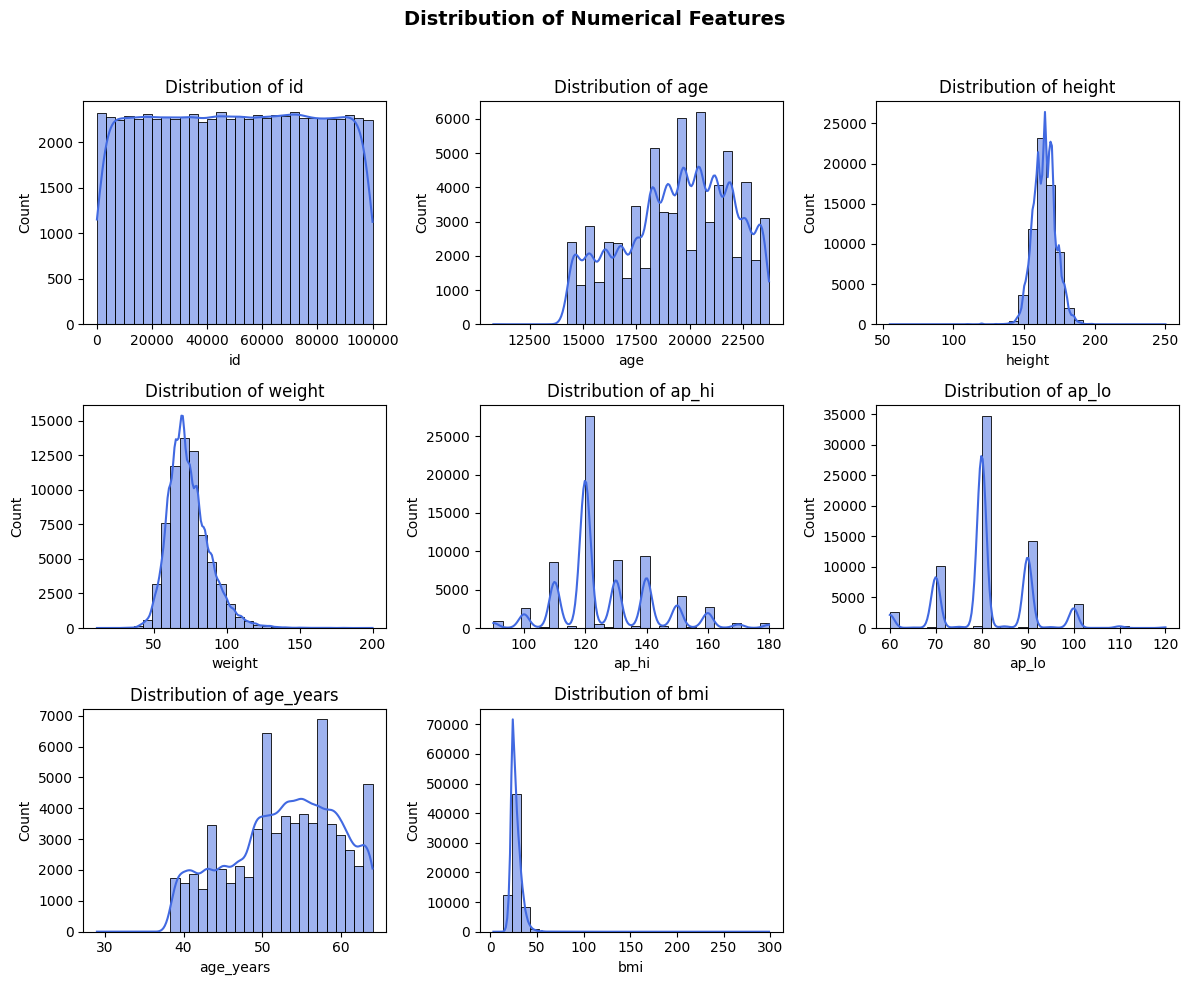

In [ ]:
# Set up the figure for numerical features histograms
num_numerical_features = len(numerical_features)
num_cols = 3  # Set a fixed number of columns for consistency
num_rows = (num_numerical_features // num_cols) + (num_numerical_features % num_cols > 0)  # Adjust rows dynamically

# Create subplots for numerical features
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))
fig.suptitle("Distribution of Numerical Features", fontsize=14, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical feature and plot histograms
for i, feature in enumerate(numerical_features):
    sns.histplot(data=data, x=feature, kde=True, bins=30, ax=axes[i], color='royalblue')
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_ylabel("Count")

# Remove any empty subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


## Summary Statistic Tables

**Numerical & Binary Features Table:** Includes min, max, mean, median, standard deviation, and missing counts.

**Ordinal Features Table:** Displays missing counts

These tables provide key insights into the dataset’s statistical properties, allowing us to identify:
  *   Missing values that may require imputation.
  *   Extreme values and potential outliers (e.g., abnormally high BMI or incorrect blood pressure readings).





In [ ]:
# Load the dataset
data = pd.read_csv(file_path)

# Classify features
numerical_features, ordinal_features, binary_features = classify_features(data)

# Check missing values for all features
missing_counts = data.isnull().sum()

# Compute additional statistics for numerical and binary features
numerical_stats = data[numerical_features].describe().transpose()
binary_stats = data[binary_features].describe().transpose()

# Add missing counts
numerical_stats["Missing Count"] = missing_counts[numerical_features]
binary_stats["Missing Count"] = missing_counts[binary_features]

# Select required columns for display
numerical_summary = numerical_stats[['min', 'max', 'mean', '50%', 'std', 'Missing Count']].rename(
    columns={'50%': 'Median', 'std': 'Std.Dev'}
)

binary_summary = binary_stats[['min', 'max', 'mean', '50%', 'std', 'Missing Count']].rename(
    columns={'50%': 'Median', 'std': 'Std.Dev'}
)

# Create summary for ordinal features with missing count only
ordinal_summary = pd.DataFrame({"Feature Name": ordinal_features, "Missing Count": missing_counts[ordinal_features].values})

# Format tables using tabulate
numerical_table = tabulate(numerical_summary.reset_index(), headers=['Feature Name', 'Min', 'Max', 'Mean', 'Median', 'Std.Dev', 'Missing Count'], tablefmt="grid", numalign="center", stralign="center")
binary_table = tabulate(binary_summary.reset_index(), headers=['Feature Name', 'Min', 'Max', 'Mean', 'Median', 'Std.Dev', 'Missing Count'], tablefmt="grid", numalign="center", stralign="center")
ordinal_table = tabulate(ordinal_summary, headers=['Feature Name', 'Missing Count'], tablefmt="grid", numalign="center", stralign="center")

# Print the updated tables
print("Numerical Features Summary:\n")
print(numerical_table)

print("\nBinary Features Summary:\n")
print(binary_table)

print("\nOrdinal Features Summary:\n")
print(ordinal_table)


Numerical Features Summary:

+----+----------------+---------+---------+---------+----------+-----------+-----------------+
|    |  Feature Name  |   Min   |   Max   |  Mean   |  Median  |  Std.Dev  |  Missing Count  |
+====+================+=========+=========+=========+==========+===========+=================+
| 0  |       id       |    0    |  99999  | 49972.4 |  50008   |  28852.1  |        0        |
+----+----------------+---------+---------+---------+----------+-----------+-----------------+
| 1  |      age       |  10798  |  23713  | 19462.7 |  19700   |  2468.38  |        0        |
+----+----------------+---------+---------+---------+----------+-----------+-----------------+
| 2  |     height     |   55    |   250   | 164.373 |   165    |  8.17676  |        0        |
+----+----------------+---------+---------+---------+----------+-----------+-----------------+
| 3  |     weight     |   11    |   200   | 74.1007 |    72    |  14.2889  |        0        |
+----+---------------

## Boxplot

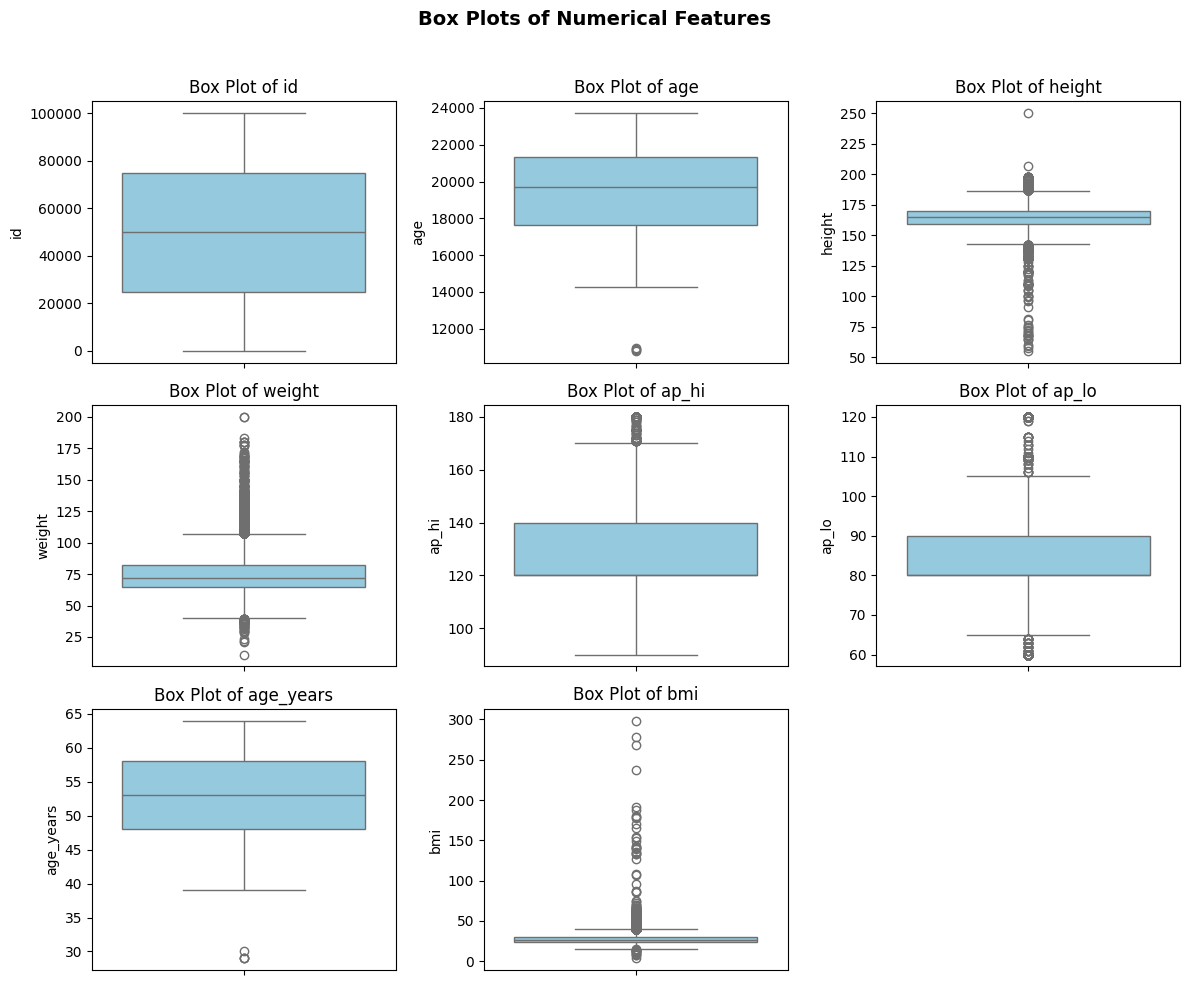

In [ ]:
# Classify features using the improved function
numerical_features, ordinal_features, binary_features = classify_features(data)

# Set up the figure for numerical features boxplots
num_numerical_features = len(numerical_features)
num_cols = 3  # Set a fixed number of columns for consistency
num_rows = (num_numerical_features // num_cols) + (num_numerical_features % num_cols > 0)  # Adjust rows dynamically

# Create subplots for numerical features
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))
fig.suptitle("Box Plots of Numerical Features", fontsize=14, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical feature and plot boxplots
for i, feature in enumerate(numerical_features):
    sns.boxplot(data=data, y=feature, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Box Plot of {feature}")

# Remove any empty subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

# Data Cleaning

## Check for missing & duplicate data

In [ ]:
# Check missing values in the dataset
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check for duplicates
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Remove duplicates
data_cleaned = data.drop_duplicates()


Missing Values:
 Series([], dtype: int64)
Number of duplicate rows: 0


## Dropping of irrelevant/ wrongly coded features

In [ ]:
# drop bp_category_encoded
data_cleaned.drop('bp_category_encoded', axis=1, inplace=True)

# drop id
data_cleaned.drop('id', axis=1, inplace=True)
numerical_features.remove('id')


## Change gender from 1, 2 to 0, 1

In [ ]:
data_cleaned['gender'] = data_cleaned['gender'].map({1: 0, 2: 1})

## Filtering Outliers Beyond 3 Standard Deviations

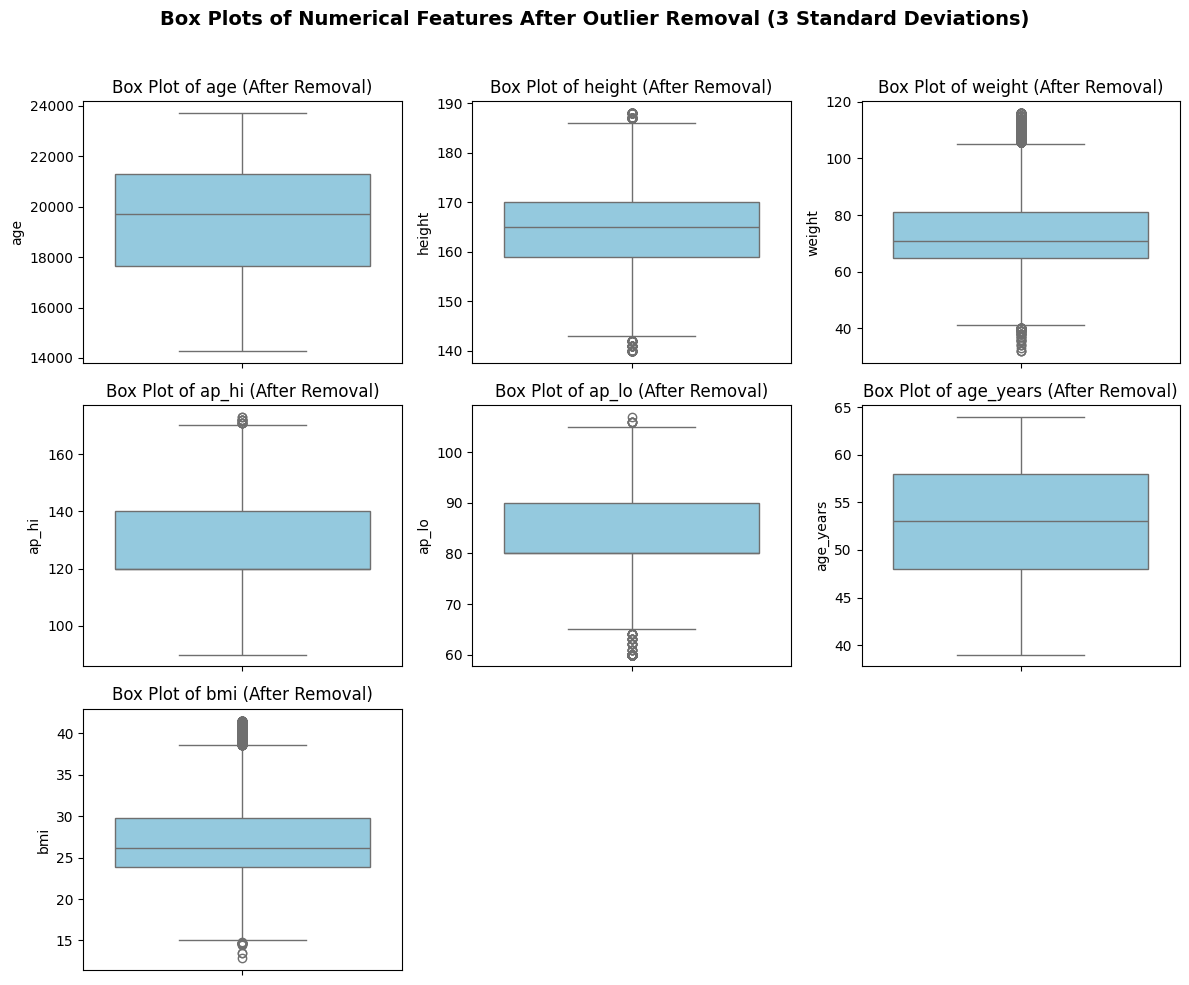

Original data size: 68205
Cleaned data size: 65686
Data removed: 2519


In [ ]:
# Function to remove outliers using 3 standard deviations from the mean for all numerical features
def remove_outliers_std_all(df, numerical_columns):
    df_cleaned = df.copy()
    for column in numerical_columns:
        mean = df_cleaned[column].mean()
        std = df_cleaned[column].std()
        lower_bound = mean - (3 * std)
        upper_bound = mean + (3 * std)
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

# Apply outlier removal to all numerical features
data_cleaned = remove_outliers_std_all(data_cleaned, numerical_features)

# Replot the box plots to check after removing outliers for all numerical features
num_numerical_features = len(numerical_features)
num_cols = 3  # Set a fixed number of columns for consistency
num_rows = (num_numerical_features // num_cols) + (num_numerical_features % num_cols > 0)  # Adjust rows dynamically

# Create subplots for numerical features
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 10))
fig.suptitle("Box Plots of Numerical Features After Outlier Removal (3 Standard Deviations)", fontsize=14, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical feature and plot boxplots
for i, feature in enumerate(numerical_features):
    sns.boxplot(data=data_cleaned, y=feature, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Box Plot of {feature} (After Removal)")

# Remove any empty subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visibility
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

print(f"Original data size: {data.shape[0]}")
print(f"Cleaned data size: {data_cleaned.shape[0]}")
print(f"Data removed: {data.shape[0] - data_cleaned.shape[0]}")


# Feature Engineering


In [ ]:
bp_category_mapping = {
    "Normal": 0,
    "Elevated": 1,
    "Hypertension Stage 1": 2,
    "Hypertension Stage 2": 3
}

# Create a new properly encoded column in data_cleaned
data_cleaned["bp_category_encoded"] = data_cleaned["bp_category"].map(bp_category_mapping)

# Drop the old bp_category column
data_cleaned.drop(columns = ['bp_category'], inplace = True)
ordinal_features.remove("bp_category")
# Create pulse-pressure variable
data_cleaned['pulse_pressure'] = data_cleaned['ap_hi'] - data_cleaned['ap_lo']
data_cleaned

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category_encoded,pulse_pressure
0,18393,1,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,2,30
1,20228,0,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,3,50
2,18857,0,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,2,60
3,17623,1,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,3,50
4,17474,0,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68198,19699,0,172,70.0,130,90,1,1,0,0,1,1,53,23.661439,2,40
68199,21074,0,165,80.0,150,80,1,1,0,0,1,1,57,29.384757,2,70
68200,19240,1,168,76.0,120,80,1,1,1,0,1,0,52,26.927438,2,40
68203,22431,0,163,72.0,135,80,1,2,0,0,0,1,61,27.099251,2,55


## Confusion Matrix

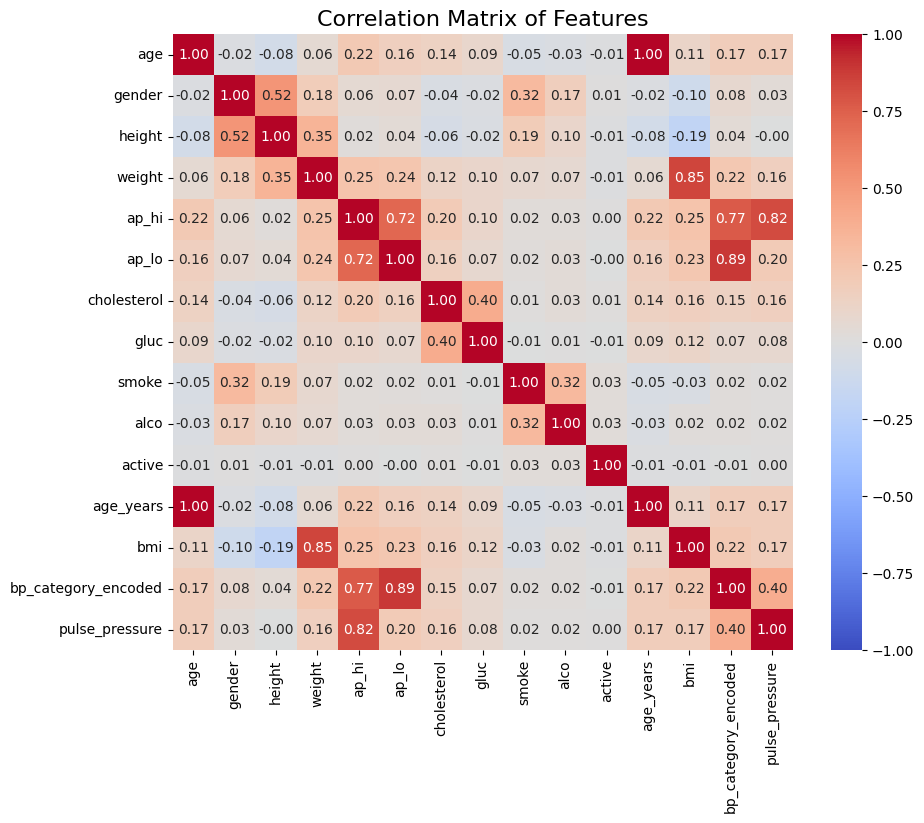

In [ ]:
# Function to calculate correlation based on variable types
def custom_correlation(data, numerical_features, ordinal_features, binary_features, col1, col2):
    col1_arr = data[col1]
    col2_arr = data[col2]
    if col1 in binary_features and col2 in binary_features:
        # Binary vs Binary (Matthews Correlation Coefficient)
        table = pd.crosstab(col1_arr, col2_arr)
        chi2, p, _, _ = chi2_contingency(table)
        return np.sqrt(chi2 / (chi2 + len(col1_arr)))

    elif col1 in binary_features and (col2 in numerical_features or col2 in ordinal_features):
        # Binary vs Numerical or Ordinal (Point-Biserial Correlation)
        return pointbiserialr(col1_arr, col2_arr)[0]

    elif col2 in binary_features and (col1 in numerical_features or col1 in ordinal_features):
        # Numerical or Ordinal vs Binary (Point-Biserial Correlation)
        return pointbiserialr(col2_arr, col1_arr)[0]

    elif col1 in ordinal_features or col2 in ordinal_features:
        # Ordinal vs Numerical or Ordinal vs Ordinal (Spearman)
        return spearmanr(col1_arr, col2_arr)[0]

    else:
        # Numerical vs Numerical (Pearson)
        return pearsonr(col1_arr, col2_arr)[0]

def create_correlation_matrix(data, numerical_features, ordinal_features, binary_features):
    features_only = data.drop(columns = ['cardio'], inplace = False)
    cols = features_only.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                corr_matrix.loc[col1, col2] = custom_correlation(features_only, numerical_features, ordinal_features, binary_features, col1, col2)

    return corr_matrix.astype(float)

correlation_matrix = create_correlation_matrix(data_cleaned, numerical_features, ordinal_features, binary_features)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

## Dropping Highly Correlated and Derived Features

In [ ]:
# drop 'age' column
data_cleaned.drop('age', axis=1, inplace=True)

# drop 'bmi' column
data_cleaned.drop('bmi', axis=1, inplace=True)

'''

#drop 'ap_hi' column
data_cleaned.drop('ap_hi', axis=1, inplace = True)

#drop 'ap_lo' column
data_cleaned.drop('ap_lo', axis=1, inplace = True)

'''

"\n\n#drop 'ap_hi' column\ndata_cleaned.drop('ap_hi', axis=1, inplace = True)\n\n#drop 'ap_lo' column\ndata_cleaned.drop('ap_lo', axis=1, inplace = True)\n\n"

## Standardisation and Min-Max Scaling of Continuous Variables

In [ ]:
scaler = StandardScaler()
data_cleaned_scaled = data_cleaned.copy()
numerical_features = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'pulse_pressure']
data_cleaned_scaled[numerical_features] = scaler.fit_transform(data_cleaned_scaled[numerical_features])

In [ ]:
data_cleaned_scaled

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_category_encoded,pulse_pressure
0,1,0.463125,-0.873002,-1.043394,-0.097473,1,1,0,0,1,0,-0.412905,2,-1.392349
1,0,-1.107092,0.933963,0.965018,1.058002,3,1,0,0,1,1,0.325344,3,0.496634
2,0,0.070571,-0.715875,0.295547,-1.252948,3,1,0,0,0,1,-0.265255,2,1.441125
3,1,0.593977,0.698272,1.634488,2.213477,1,1,0,0,1,1,-0.708204,3,0.496634
4,0,-1.107092,-1.344384,-1.712865,-2.408423,1,1,0,0,0,0,-0.855854,0,-0.447858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68198,0,0.986531,-0.244493,0.295547,1.058002,1,1,0,0,1,1,0.030044,2,-0.447858
68199,0,0.070571,0.541144,1.634488,-0.097473,1,1,0,0,1,1,0.620643,2,2.385616
68200,1,0.463125,0.226890,-0.373924,-0.097473,1,1,1,0,1,0,-0.117605,2,-0.447858
68203,0,-0.191132,-0.087365,0.630282,-0.097473,1,2,0,0,0,1,1.211242,2,0.968879


# Export cleaned dataset

In [ ]:
data_cleaned_scaled.to_csv('data_cleaned.csv', index=False)
files.download('data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Code chunk for data set splitting

In [ ]:
# 60/20/20 train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify = y, random_state=4240)  # 60% train, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify = y_temp, random_state=4240)  # 20% val, 20% test

this code chunk shld be under regression model file since only regression models may need interaction terms

In [ ]:
# create an interaction term for height and weight and check if p value is smaller than 0.05 , if not then don't include the interaction term
import statsmodels.api as sm
data_cleaned_scaled['height_weight'] = data_cleaned_scaled['weight'] * data_cleaned_scaled['height']

# Define independent variables (including the interaction term)
X = data_cleaned_scaled[['height', 'weight', 'height_weight']]
X = sm.add_constant(X)  # Add intercept

# Define dependent variable (Ensure 'target' is binary: 0 or 1)
y = data_cleaned_scaled['cardio']

# Fit Logistic Regression Model
logit_model = sm.Logit(y, X).fit()

# Display model summary
print(logit_model.summary())

# Extract p-value for the interaction term
p_value = logit_model.pvalues['height_weight']

# Print significance result
if p_value < 0.05:
    print(f"The height_weight interaction term is significant (p-value = {p_value:.5f})")
else:
    print(f"The height_weight interaction term is NOT significant (p-value = {p_value:.5f})")

data_cleaned_scaled.describe()